# TL; DR:
- least_squares() beats minimize() in speed and reproducibility
- Trying to minimize futile cycles by penalizing all flux does not work well
  - The optimizer does not always converge, particularly with minimize()
  - When it does converge, the constraint introduces artifacts into the solution
- An alternative approach to break futile cycles seems to work well

Changes were needed to this notebook to reproduce its behavior before the branch 'futile' and revision 39da4196528af413112ecf304a2dea070d023180, implementing the very changes it suggests.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix

from mosmo.model import Molecule, Reaction, Pathway
from mosmo.knowledge import kb
from mosmo.calc import fba_gd

KB = kb.configure_kb()

jax.config.update('jax_enable_x64', True)

# Setup: PTS + glycolysis + PPP; objectives from [R5P, E4P, PEP, acCoA]

In [2]:
pw = KB('glycolysis_ppp_ov')

glc_e = KB('Glc.D.ext')
r5p = KB('Rib.D.5P')
e4p = KB('Ery.D.4P')
pep = KB('pep')
pyr = KB('pyr')
acCoA = KB('accoa')

concs = {KB(met_id): conc for met_id, conc in [
    ('accoa', 0.61),
    ('adp', 0.55),
    ('amp', 0.28),
    ('atp', 9.6),
    ('co2', 0.01),
    ('coa', 1.4),
    ('h+', 1e-7),
    ('h2o', 55500.),
    ('nad.ox', 2.6),
    ('nad.red', 0.083),
    ('nadp.ox', 0.0021),
    ('nadp.red', 0.12),
    ('pep', 0.18),
    ('pyr', 0.1),  # guess
    ('pi', 10.),  # guess
    ('Rib.D.5P', 0.8),  # guess
    ('Ery.D.4P', 0.8),  # guess    
    ('Glc.D.ext', 10.),  # arbitrary
]}
boundaries = concs.keys()
intermediates = [met for met in pw.molecules if met not in boundaries]

# Legacy Code

## Straight glycolysis to acCoA

In [3]:
import time

# Reconstructing existing code, before 39da4196528af413112ecf304a2dea070d023180
def l_pt5(residual):
    return jnp.sum(jnp.sqrt(jnp.abs(residual)))

def l2(residual):
    return jnp.sum(jnp.square(residual))

class LegacyObjective(fba_gd.Objective):
    def __init__(self, objective, aggfun=l2):
        self.objective = objective
        self.weight = objective.weight
        self.aggfun = aggfun

    def update_params(self, params):
        self.objective.update_params(params)

    def params(self):
        return self.objective.params()

    def residual(self, velocities, dmdt, params):
        return self.objective.residual(velocities, dmdt, params)

    def loss(self, velocities, dmdt, params):
        return self.objective.weight * self.aggfun(self.objective.residual(velocities, dmdt, params))

class LegacyFbaGd:
    def __init__(self, pw, intermediates, objectives, w_fitness=1e4, w_sparsity=1e-4):
        self.pw = pw
        self.objectives = {
            'steady-state': LegacyObjective(fba_gd.SteadyStateObjective(pw, intermediates, weight=w_fitness)),
            'irreversibility': LegacyObjective(fba_gd.IrreversibilityObjective(pw, weight=w_fitness)),
            'sparsity': LegacyObjective(fba_gd.VelocityObjective(pw, {r: 0 for r in pw.reactions}, weight=w_sparsity), aggfun=l_pt5),
        }
        self.objectives.update(objectives)

        def loss(v, *params):
            dmdt = self.pw.s_matrix @ v
            return sum(objective.loss(v, dmdt, p) for objective, p in zip(self.objectives.values(), params))

        # Cache the jitted loss and jacobian functions
        self._loss_jit = jax.jit(loss)
        self._loss_jac = jax.jit(jax.jacfwd(loss))

    def update_params(self, updates):
        for name, params in updates.items():
            self.objectives[name].update_params(params)

    def solve(self, v0=None, seed=None, **kw_args):
        if v0 is None:
            if seed is None:
                seed = jax.random.PRNGKey(int(time.time() * 1000))
            v0 = jax.random.normal(seed, self.pw.shape[1:])

        params = tuple(objective.params() for objective in self.objectives.values())
        soln = scipy.optimize.minimize(fun=self._loss_jit, args=params, x0=v0, jac=self._loss_jac, **kw_args)

        dmdt = self.pw.s_matrix @ soln.x
        return fba_gd.FbaResult(v0=v0,
                                velocities=soln.x,
                                dmdt=dmdt,
                                fit=sum(float(self.objectives[name].loss(soln.x, dmdt, None))
                                        for name in ['steady-state', 'irreversibility']))

fba = LegacyFbaGd(
    pw,
    intermediates,
    {
        'drivers': LegacyObjective(fba_gd.ProductionObjective(pw, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0.})),
    }
)
soln = fba.solve()

In [4]:
for m, dmdt in pw.molecules.unpack(soln.dmdt).items():
    print(f'{m.label:>12s}: {dmdt:7.4f} {"[SS]" if m in intermediates else ""}')

         GAP:  0.0000 [SS]
        NAD+: -0.1185 
          Pi:  2.1136 
         DPG: -0.0000 [SS]
          H+: 21.7507 
        NADH:  0.1185 
         3PG:  0.0000 [SS]
         ATP: -1.8774 
         ADP:  1.6410 
         2PG: -0.0000 [SS]
         H2O: -11.8730 
         PEP: -0.0004 
         pyr: -0.0003 
         AMP:  0.2363 
         CoA: -0.0597 
       acCoA:  0.0597 
         CO2:  9.8191 
        DHAP:  0.0000 [SS]
         FDP:  0.0000 [SS]
         F6P:  0.0000 [SS]
         G6P:  0.0000 [SS]
         R5P:  0.0002 
        Ru5P: -0.0000 [SS]
       6PGDL: -0.0000 [SS]
         6PG: -0.0000 [SS]
       NADP+: -19.5190 
       NADPH: 19.5190 
        Xu5P:  0.0000 [SS]
        KDPG: -0.0000 [SS]
      Glc[e]: -1.6564 
         acP: -0.0000 [SS]
          ac: -0.0000 [SS]
         PPi:  0.0000 [SS]
       Sed7P:  0.0000 [SS]
         E4P:  0.0002 


In [5]:
for r, v in pw.reactions.unpack(soln.velocities).items():
    print(f"{r.label:>12s}: {v:7.4f}")

       GAPDH:  0.0588
         PGK: -0.0588
         GPM: -0.0588
         ENO:  0.0588
         PPS:  0.2363
         PDH:  0.0597
         PYK:  1.3609
         TPI:  1.5972
         FBA: -1.5972
         PFK:  0.3389
         PGI: -8.1032
         RPI: -3.2534
      PGLase:  9.7597
       G6PDH:  9.7597
       PGLDH:  9.7594
         RPE:  6.5060
         FBP:  1.9361
     PGLDhat:  0.0003
       KDPGA:  0.0003
      GlcPTS:  1.6564
         PTA:  0.0000
         ACK: -0.0000
    ACCOAlig:  0.0000
        TKT1: -3.2531
        TALA:  3.2531
        TKT2:  3.2529


Not a compelling solution. What if we manufacture the known 'best' (or at least intended) solution?

In [6]:
optimal = {KB(rxn_id): v for rxn_id, v in [
    ('pts.glc',  0.03),
    ('pgi', 0.03),
    ('pfk',  0.03),
    ('fbp',  0.),
    ('fba', 0.03),
    ('tpi',  -0.03),
    ('gapdh',  0.06),
    ('pgk', -0.06),
    ('gpm', -0.06),
    ('eno',  0.06),
    ('pyk',  -0.03),
    ('pps',  0.),
    ('pdh',  0.06),
    ('r5pi', 0.),
    ('tkt.c5c5', 0.),
    ('rpe',  0.),
    ('pglase',  0.),
    ('pgldh',  0.),
    ('tal',  0.),
    ('tkt.c5c4',  0.),
    ('g6pdh',  0.),
]}
optimal_array = pw.reactions.pack(optimal)
dmdt = pw.s_matrix @ optimal_array

for key, obj in fba.objectives.items():
    print(key, obj.residual(optimal_array, dmdt, obj.params()))

steady-state [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
irreversibility [0. 0. 0. 0. 0. 0. 0. 0.]
sparsity [ 0.06 -0.06 -0.06  0.06  0.    0.06 -0.03 -0.03  0.03  0.03  0.03  0.
  0.    0.    0.    0.    0.    0.    0.    0.03  0.    0.    0.    0.
  0.    0.  ]
drivers [0. 0. 0. 0. 0.]


In [7]:
jiggle = np.zeros(optimal_array.shape)
# jiggle = 0.00001 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(soln.velocities, soln.velocities - optimal_array)
for key, obj in fba.objectives.items():
    print(key, obj.residual(soln.velocities, soln.dmdt, obj.params()))

         Current function value: 0.000226
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
[ 0.06 -0.06 -0.06  0.06  0.    0.06 -0.03 -0.03  0.03  0.03  0.03  0.
  0.    0.    0.    0.    0.    0.    0.    0.03  0.    0.    0.    0.
  0.    0.  ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
steady-state [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
irreversibility [0. 0. 0. 0. 0. 0. 0. 0.]
sparsity [ 0.06 -0.06 -0.06  0.06  0.    0.06 -0.03 -0.03  0.03  0.03  0.03  0.
  0.    0.    0.    0.    0.    0.    0.    0.03  0.    0.    0.    0.
  0.    0.  ]
drivers [0. 0. 0. 0. 0.]


/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: NaN result encountered.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


With minimize() and the above objective:
- jiggle = 0 ==> Warning: NaN result encountered.
- jiggle = _any_ non-zero, even very small ==> Warning: Desired error not necessarily achieved due to precision loss.

**Not** working as intended

## Try it in μM to give more breathing room on the bottom

In [8]:
fba.update_params({'drivers': {acCoA: 60.}})
jiggle = 1e-6 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array*1000 + jiggle, options={'disp': True})
print(soln.velocities, soln.velocities - optimal_array*1000)
for key, obj in fba.objectives.items():
    print(key, obj.residual(soln.velocities, soln.dmdt, obj.params()))

         Current function value: 0.007160
         Iterations: 1
         Function evaluations: 55
         Gradient evaluations: 47
[ 6.00000011e+01 -6.00000004e+01 -5.99999988e+01  5.99999992e+01
 -1.47968173e-06  6.00000014e+01 -3.00000007e+01 -3.00000004e+01
  3.00000011e+01  3.00000015e+01  3.00000003e+01  2.29872098e-07
 -3.86511376e-07 -8.08211924e-09  6.63385625e-07  2.63108712e-07
  5.94706108e-07 -1.19950309e-06  1.81493487e-07  3.00000007e+01
  2.47685171e-07  5.18592422e-07  3.29107133e-07  2.49935649e-07
  4.20601630e-07  3.53393565e-07] [ 1.12691280e-06 -4.27316834e-07  1.20409419e-06 -8.32982899e-07
 -1.47968173e-06  1.41668430e-06 -6.64629237e-07 -3.75855365e-07
  1.10693514e-06  1.46577622e-06  2.83942295e-07  2.29872098e-07
 -3.86511376e-07 -8.08211924e-09  6.63385625e-07  2.63108712e-07
  5.94706108e-07 -1.19950309e-06  1.81493487e-07  7.47732951e-07
  2.47685171e-07  5.18592422e-07  3.29107133e-07  2.49935649e-07
  4.20601630e-07  3.53393565e-07]
steady-state [ 2.20

/home/fdrusso/.pyenv/versions/3.11.2/envs/mosmo-work/lib/python3.11/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Same result. Comforting, I guess...

## Still using scipy.optimize.minimize, but remove sparsity objective (which is on a very different scale)

In [9]:
fba = LegacyFbaGd(
    pw,
    intermediates,
    {'drivers': LegacyObjective(fba_gd.ProductionObjective(pw, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0.})),},
    w_sparsity=0.,
)
jiggle = 1e-4 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(soln.velocities, soln.velocities - optimal_array)
for r, v in pw.reactions.unpack(soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 52
         Gradient evaluations: 52
[ 5.99604723e-02 -5.99604723e-02 -5.99604723e-02  5.99604723e-02
  1.36379010e-06  5.99999911e-02 -2.99618504e-02 -2.99604803e-02
  2.99604803e-02  2.99900687e-02  2.99604687e-02 -6.10317041e-09
  3.95228647e-05  3.95228632e-05  1.77004722e-08  1.16045571e-08
  2.95883349e-05  3.95051584e-05  3.95051542e-05  2.99999916e-02
 -3.05303911e-12  4.15060342e-14  8.22394455e-13 -5.15726579e-09
  5.15623442e-09  6.44680093e-09] [-3.95277040e-05  3.95277054e-05  3.95277074e-05 -3.95277110e-05
  1.36379010e-06 -8.86666361e-09  3.81495711e-05  3.95196527e-05
 -3.95196527e-05 -9.93131726e-06 -3.95312563e-05 -6.10317041e-09
  3.95228647e-05  3.95228632e-05  1.77004722e-08  1.16045571e-08
  2.95883349e-05  3.95051584e-05  3.95051542e-05 -8.39095565e-09
 -3.05303911e-12  4.15060342e-14  8.22394455e-13 -5.15726579e-09
  5.15623442e-

### Manually break futile cycles

In [10]:
fba = LegacyFbaGd(
    pw,
    intermediates,
    {
        'drivers': LegacyObjective(fba_gd.ProductionObjective(pw, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0.}, weight=100.)),
        'non-futility': LegacyObjective(fba_gd.VelocityObjective(pw, {
            KB.get(KB.reactions, 'fbp'): 0.,
            KB.get(KB.reactions, 'pps'): 0.,
        })),
    },
    w_sparsity=0.,
)
jiggle = 1e-2 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(soln.velocities)
print(np.sum(np.square(soln.velocities - optimal_array)))
for r, v in pw.reactions.unpack(soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 68
         Function evaluations: 96
         Gradient evaluations: 96
[ 5.58780687e-02 -5.58780687e-02 -5.58780687e-02  5.58780687e-02
 -1.41994911e-10  6.00000000e-02 -2.58724402e-02 -2.58724404e-02
  2.58724404e-02  2.58724404e-02  2.58499271e-02 -1.12566320e-05
  4.15570120e-03  4.15570120e-03  3.37698962e-05  2.25132645e-05
  3.98109605e-12  4.12193130e-03  4.12193130e-03  3.00056283e-02
 -1.10832126e-13 -5.59875836e-14 -4.21468891e-14 -1.12566321e-05
  1.12566319e-05  1.12566324e-05]
0.00022185389595166224
               gapdh:  0.05588
                 pgk: -0.05588
                 gpm: -0.05588
                 eno:  0.05588
                 pps: -0.00000
                 pdh:  0.06000
                 pyk: -0.02587
                 tpi: -0.02587
                 fba:  0.02587
                 pfk:  0.02587
                 pgi:  0.02585
                r5pi: -0.00001
         

At least it appears to consistently find a solution. Doesn't knock my socks off though.

- Wait, this could be legitimate. We have set an objective for acCoA production, and that is being met exactly (PDH velocity = 0.06000). Some unexpected flux is going through PPP, spending a little extra G6P and getting some NADPH + CO2, but none of our objectives discourage that. If we force 1 G6P => 2 acCoA, or alternatively NADPH = 0, it could consistently find the same (optimal) solution.

In [11]:
fba = LegacyFbaGd(
    pw,
    intermediates,
    {
        'drivers': LegacyObjective(
            fba_gd.ProductionObjective(pw, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB('Glc.D.ext'): -0.03})),
        'non-futility': LegacyObjective(fba_gd.VelocityObjective(pw, {KB('fbp'): 0., KB('pps'): 0.})),
    },
    w_sparsity=0.,
)
jiggle = 1e-1 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
soln = fba.solve(v0=optimal_array + jiggle, options={'disp': True})
print(np.sum(np.square(soln.velocities - optimal_array)))
print()
for r, v in pw.reactions.unpack(soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 109
         Function evaluations: 206
         Gradient evaluations: 206
0.011617081454860258

               gapdh:  0.03017
                 pgk: -0.03017
                 gpm: -0.03017
                 eno:  0.03017
                 pps:  0.00000
                 pdh:  0.05999
                 pyk: -0.00016
                 tpi: -0.00013
                 fba:  0.00013
                 pfk:  0.00013
                 pgi: -0.00005
                r5pi: -0.00007
              pglase:  0.03007
               g6pdh:  0.03007
               pgldh:  0.00026
                 rpe:  0.00018
                 fbp:  0.00000
             pgldhat:  0.02981
               kdpga:  0.02981
             pts.glc:  0.03001
                 pta: -0.00000
                 ack:  0.00000
               aclig: -0.00000
            tkt.c5c5: -0.00009
                 tal:  0.00009
            tkt.c5c4:  0.000

Ok, that's viable

## Using scipy.optimize.least_squares, with catenated residual vectors

In [12]:
objectives = {
    'steady-state': fba_gd.SteadyStateObjective(pw, intermediates, weight=1e4),
    'irreversibility': fba_gd.IrreversibilityObjective(pw, weight=1e4),
    'drivers': fba_gd.ProductionObjective(pw, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB('Glc.D.ext'): -0.03}),
    'non-futility': fba_gd.VelocityObjective(pw, {KB('fbp'): 0., KB('pps'): 0.}),
}

def residual(v, *params):
    dmdt = pw.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

# Cache the jitted loss and jacobian functions
_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

jiggle = 1e-1 * jax.random.normal(jax.random.PRNGKey(0), optimal_array.shape)
v0=optimal_array + jiggle

params = tuple(objective.params() for objective in objectives.values())
soln = scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=v0, jac=_loss_jac)
print(soln.message)

dmdt = pw.s_matrix @ soln.x
fba_soln = fba_gd.FbaResult(v0=np.asarray(v0),
                            velocities=np.asarray(soln.x),
                            dmdt=np.asarray(dmdt),
                            fit=sum(np.sum(np.square(objectives[name].loss(soln.x, dmdt, None))) for name in ['steady-state', 'irreversibility']))
print(np.sum(np.square(fba_soln.velocities - optimal_array)))
print()
for r, v in pw.reactions.unpack(fba_soln.velocities).items():
    print(f"{r.id:>20}: {v:8.5f}")


`gtol` termination condition is satisfied.
3.238158700876833e-29

               gapdh:  0.06000
                 pgk: -0.06000
                 gpm: -0.06000
                 eno:  0.06000
                 pps: -0.00000
                 pdh:  0.06000
                 pyk: -0.03000
                 tpi: -0.03000
                 fba:  0.03000
                 pfk:  0.03000
                 pgi:  0.03000
                r5pi:  0.00000
              pglase:  0.00000
               g6pdh:  0.00000
               pgldh:  0.00000
                 rpe:  0.00000
                 fbp:  0.00000
             pgldhat: -0.00000
               kdpga: -0.00000
             pts.glc:  0.03000
                 pta:  0.00000
                 ack:  0.00000
               aclig: -0.00000
            tkt.c5c5:  0.00000
                 tal: -0.00000
            tkt.c5c4:  0.00000


# Methodical comparison over 100 trials

In [13]:
v0 = jax.random.normal(jax.random.PRNGKey(0), (100, pw.shape[1]))

### with scipy.optimize.minimize, improved as above

In [14]:
fba = LegacyFbaGd(
    pw,
    intermediates,
    {
        'drivers': LegacyObjective(
            fba_gd.ProductionObjective(pw, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., glc_e: -0.03})),
        'non-futility': LegacyObjective(fba_gd.VelocityObjective(pw, {KB('fbp'): 0., KB('pps'): 0.})),
    },
    w_sparsity=0.,
)

In [15]:
%%time
results_a = [fba.solve(v0=trial).velocities for trial in v0]

CPU times: user 7.15 s, sys: 7.15 ms, total: 7.16 s
Wall time: 7.15 s


### same problem with scipy.optimize.least_squares

In [16]:
objectives = {
    'steady-state': fba_gd.SteadyStateObjective(pw, intermediates, weight=1e4),
    'irreversibility': fba_gd.IrreversibilityObjective(pw, weight=1e4),
    'drivers': fba_gd.ProductionObjective(pw, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., glc_e: -0.03}),
    'non-futility': fba_gd.VelocityObjective(pw, {KB('fbp'): 0., KB('pps'): 0.}),
}

def residual(v, *params):
    dmdt = pw.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

params = tuple(objective.params() for objective in objectives.values())

In [17]:
%%time
results_b = [scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=trial, jac=_loss_jac).x for trial in v0]

CPU times: user 597 ms, sys: 0 ns, total: 597 ms
Wall time: 596 ms


So, conservatively ~8x faster

In [18]:
# Pathway reactions are not guaranteed to be in any particular order. Define one for interpretability
steps = [KB(rxn_id) for rxn_id in ['pts.glc', 'pgi', 'pfk', 'fba', 'tpi', 'gapdh', 'pgk', 'gpm', 'eno', 'pyk', 'pdh']]
isteps = [pw.reactions.index_of(step) for step in steps]
step_labels = np.array(pw.reactions.labels())[isteps]
print(' -> '.join(step_labels))
for r, v in pw.reactions.unpack(optimal_array).items():
    if v != 0 and r not in steps:
        print(r, v)

GlcPTS -> PGI -> PFK -> FBA -> TPI -> GAPDH -> PGK -> GPM -> ENO -> PYK -> PDH


/tmp/ipykernel_99830/3726135510.py:3: RuntimeWarning: invalid value encountered in log
  ax[0].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')
/tmp/ipykernel_99830/3726135510.py:5: RuntimeWarning: invalid value encountered in log
  ax[1].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')
/tmp/ipykernel_99830/3726135510.py:5: RuntimeWarning: divide by zero encountered in log
  ax[1].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')


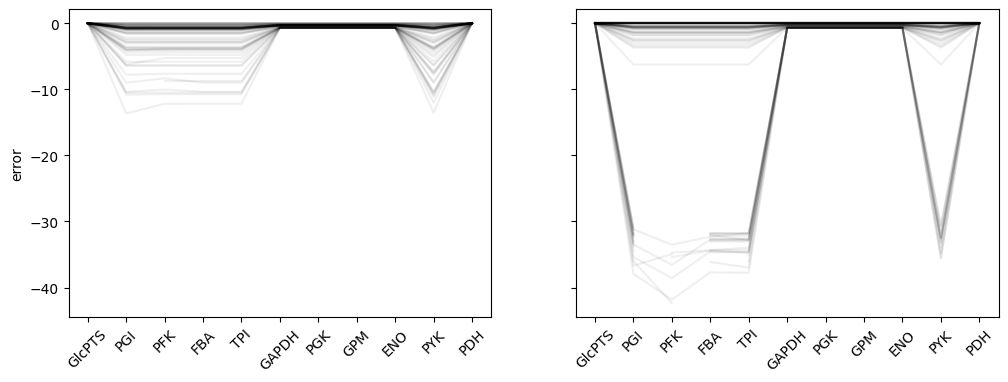

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
for result in results_a:
    ax[0].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')
for result in results_b:
    ax[1].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')

ax[0].set_ylabel('error')
ax[0].set_xticks(range(len(step_labels)), step_labels, rotation=45)
ax[1].set_xticks(range(len(step_labels)), step_labels, rotation=45)
plt.show()

And waaay more consistent

In [20]:
rms_error_a = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_a]
print(f'minimize() rms error vs optimal: {np.mean(rms_error_a):.2e}')
rms_error_b = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_b]
print(f'least_squares() rms error vs optimal: {np.mean(rms_error_b):.2e}')

minimize() rms error vs optimal: 1.37e-02
least_squares() rms error vs optimal: 9.94e-03


### One more time, with previous sparsity objective but using least_squares

In [21]:
objectives = {
    'steady-state': LegacyObjective(fba_gd.SteadyStateObjective(pw, intermediates, weight=1e4)),
    'irreversibility': LegacyObjective(fba_gd.IrreversibilityObjective(pw, weight=1e4)),
    'drivers': LegacyObjective(
        fba_gd.ProductionObjective(pw, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., glc_e: -0.03})),
    # 'non-futility': fba_gd.VelocityObjective(pw, {KB('fbp'): 0., KB('pps'): 0.}),
    'sparsity': LegacyObjective(fba_gd.VelocityObjective(pw, {rxn: 0.0 for rxn in pw.reactions}, weight=1e-4), aggfun=l_pt5)
}

def residual(v, *params):
    dmdt = pw.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

params = tuple(objective.params() for objective in objectives.values())

In [22]:
%%time
results_c = [scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=trial, jac=_loss_jac).x for trial in v0]

CPU times: user 504 ms, sys: 3.93 ms, total: 508 ms
Wall time: 507 ms


/tmp/ipykernel_99830/2342835112.py:3: RuntimeWarning: invalid value encountered in log
  ax[0].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')
/tmp/ipykernel_99830/2342835112.py:3: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')
/tmp/ipykernel_99830/2342835112.py:5: RuntimeWarning: invalid value encountered in log
  ax[1].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')


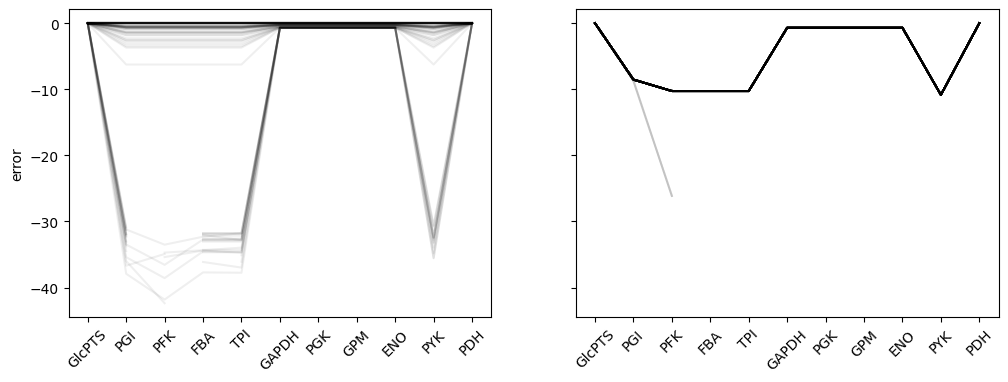

least_squares() with sparsity objective, rms error vs optimal: 2.12e-02


In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
for result in results_b:
    ax[0].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')
for result in results_c:
    ax[1].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')

ax[0].set_ylabel('error')
ax[0].set_xticks(range(len(step_labels)), step_labels, rotation=45)
ax[1].set_xticks(range(len(step_labels)), step_labels, rotation=45)
plt.show()

rms_error_c = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_c]
print(f'least_squares() with sparsity objective, rms error vs optimal: {np.mean(rms_error_c):.2e}')

Unexpected: not just worse, but consistently incorrect, or at least not the intended optimal solution.

In [24]:
soln = scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=v0[0], jac=_loss_jac, verbose=2)
dmdt = pw.s_matrix @ soln.x
print(f"Fit: {sum(float(objectives[name].loss(soln.x, dmdt, None)) for name in ['steady-state', 'irreversibility'])}")
print(soln.x[isteps] / optimal_array[isteps])

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5249e+05                                    5.07e+04    
       1              2         2.8073e-01      1.52e+05       4.47e+00       7.49e+01    
       2              3         1.2411e-03      2.79e-01       2.33e-01       4.96e+00    
       3              4         5.9094e-07      1.24e-03       9.63e-04       1.07e-02    
       4              5         5.8475e-07      6.19e-09       1.56e-06       3.76e-14    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 1.5249e+05, final cost 5.8475e-07, first-order optimality 3.76e-14.
Fit: 7.706985229218e-14
[9.99692452e-01 1.96397444e-04 3.49007624e-05 3.48800070e-05
 3.48696291e-05 4.99707949e-01 4.99707949e-01 4.99707953e-01
 4.99707963e-01 1.94657583e-05 9.99751979e-01]


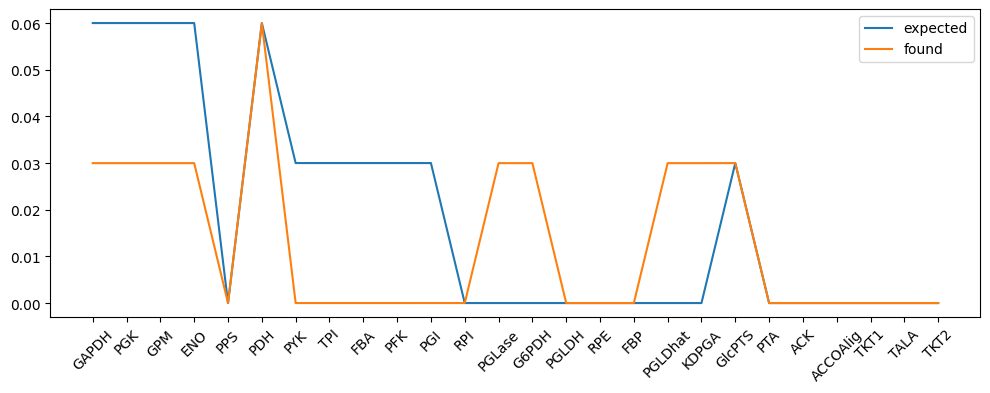

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(optimal_array), label='expected')
ax.plot(np.abs(soln.x), label='found')
ax.set_xticks(range(pw.shape[1]), pw.reactions.labels(), rotation=45)
plt.legend()
plt.show()


**Narrative**: 
- We disincentivize _all_ non-zero flux, with an L2 loss funciton.
- The system can reduce flux through PGI by bypassing via PPP.
- The beneift of reducing (squared) PGI flux compensates for the penalty of increased Glc consumption and/or reduced acCoA production.
- This is an uninteded artifact of the method we use to minimize futile cycles. An alternative approach is better.

### Build an objective explicitly to minimize flux in a futile cycle
- Added benefit: optimality drives the residual to zero instead of minimizing a positive number

In [26]:
class ExclusionObjective(fba_gd.Objective):
    """Incentivizes mutually exclusive fluxes within a set of reactions."""

    def __init__(self, pw, reactions, weight=1.0):
        super().__init__(weight=weight)
        self.pw = pw
        self.indices = np.array([pw.reactions.index_of(rxn) for rxn in reactions], dtype=np.int32)

    def residual(self, velocities, dmdt, params=None):
        return jnp.prod(velocities[self.indices], keepdims=True)


In [27]:
objectives = {
    'steady-state': LegacyObjective(fba_gd.SteadyStateObjective(pw, intermediates, weight=1e4)),
    'irreversibility': LegacyObjective(fba_gd.IrreversibilityObjective(pw, weight=1e4)),
    'drivers': LegacyObjective(
        fba_gd.ProductionObjective(pw, {acCoA: 0.06, pep: 0., pyr:  0., r5p: 0., e4p: 0., KB('Glc.D.ext'): -0.03})),
    'non-futility-fbp': LegacyObjective(ExclusionObjective(pw, [KB('fbp'), KB('pfk')])),
    'non-futility-pps': LegacyObjective(ExclusionObjective(pw, [KB('pps'), KB('pyk')])),
}

def residual(v, *params):
    dmdt = pw.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdt, p) * np.sqrt(objective.weight)
                            for objective, p in zip(objectives.values(), params)])

_loss_jit = jax.jit(residual)
_loss_jac = jax.jit(jax.jacfwd(residual))

params = tuple(objective.params() for objective in objectives.values())

In [28]:
%%time
results_d = [scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=trial, jac=_loss_jac).x for trial in v0]

CPU times: user 648 ms, sys: 0 ns, total: 648 ms
Wall time: 647 ms


/tmp/ipykernel_99830/863830209.py:4: RuntimeWarning: invalid value encountered in log
  ax[0].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')
/tmp/ipykernel_99830/863830209.py:4: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')
/tmp/ipykernel_99830/863830209.py:7: RuntimeWarning: invalid value encountered in log
  ax[1].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')


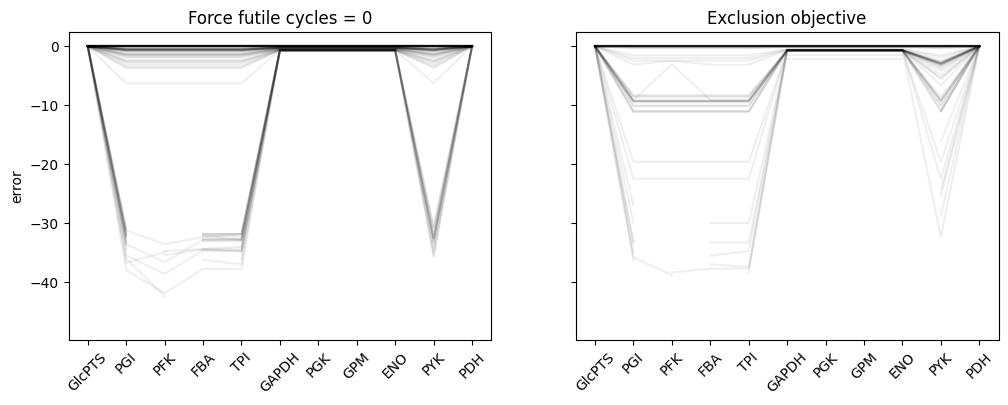

least_squares() with exclusion objective, rms error vs optimal: 6.23e-02


In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='all')
ax[0].set_title("Force futile cycles = 0")
for result in results_b:
    ax[0].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')
ax[1].set_title("Exclusion objective")
for result in results_d:
    ax[1].plot(np.log(result[isteps] / optimal_array[isteps]), color='#00000010')

ax[0].set_ylabel('error')
ax[0].set_xticks(range(len(step_labels)), step_labels, rotation=45)
ax[1].set_xticks(range(len(step_labels)), step_labels, rotation=45)
plt.show()

rms_error_d = [np.sqrt(np.mean(np.square(result - optimal_array))) for result in results_d]
print(f'least_squares() with exclusion objective, rms error vs optimal: {np.mean(rms_error_d):.2e}')

- Better than sparsity, not as good as a pure zero velocity objective. 
- It does at least specifically target futile cycles.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5249e+05                                    5.07e+04    
       1              2         2.1173e-02      1.52e+05       4.58e+00       1.32e+01    
       2              3         7.4886e-04      2.04e-02       2.72e-01       7.32e-03    
       3              4         4.1989e-05      7.07e-04       2.70e-01       8.77e-04    
       4              9         1.2286e-05      2.97e-05       3.58e-02       3.49e-04    
       5             10         7.6789e-07      1.15e-05       4.98e-02       4.36e-05    
       6             12         1.2911e-07      6.39e-07       1.79e-02       1.15e-05    
       7             14         3.4536e-08      9.46e-08       8.95e-03       4.26e-06    
       8             15         7.3723e-10      3.38e-08       1.79e-02       3.63e-03    
       9             16         4.9658e-12      7.32e-10       2.51e-03       5.59e-09    

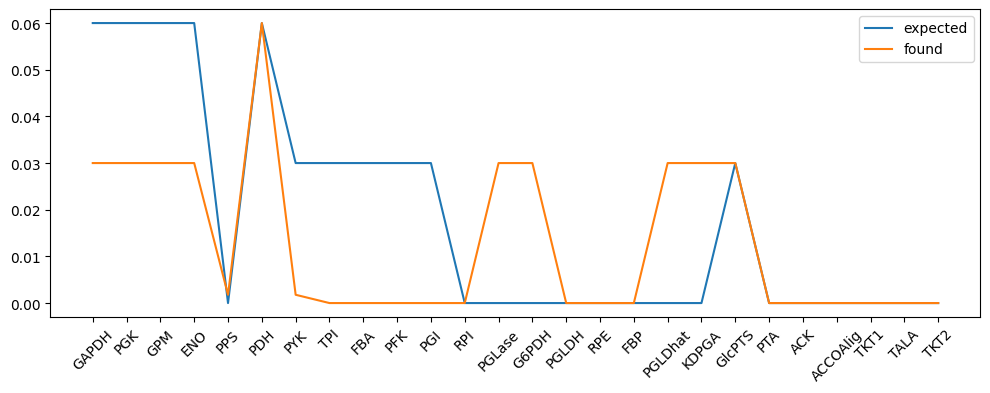

In [30]:
soln = scipy.optimize.least_squares(fun=_loss_jit, args=params, x0=v0[0], jac=_loss_jac, verbose=2)
dmdt = pw.s_matrix @ soln.x
print(f"Fit: {sum(float(objectives[name].loss(soln.x, dmdt, None)) for name in ['steady-state', 'irreversibility'])}")
print(soln.x - optimal_array)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(optimal_array), label='expected')
ax.plot(np.abs(soln.x), label='found')
ax.set_xticks(range(pw.shape[1]), pw.reactions.labels(), rotation=45)
plt.legend()
plt.show()


**Conclusion**
- The graph two cells above highlights the difference between the exclusion objective and blocking FBP and PPS directly. But that difference is actually quite small, < ~0.03%
- The exclusion objective is flexible with respect to overall direction, where blocking specific fluxes would need to know which direction is expected.
- The tradeoff could be well worth it.